# Tutorial 2: Increasing the radius ratio knot resolution

**Author:** Hannu Parviainen <br>
**Edited:** 31 October 2024

The resolution of the transmission spectrum estimated by ExoIris depends on two factors: 
1. the intrinsic spectroscopic resolution of the data, and
2. the number and locations of the radius ratio spline knots.
   
While both can be modified before starting a new analysis, ExoIris also makes it extremely easy to start from a lower-resolution result and add more detail where it is required. Here, we see how to create a new analysis using the saved results from [Tutorial 1](01a_not_so_short_intro.ipynb), add radius ratio knots to the model, and estimate the transmission spectrum with this more complex model. Of course, nothing stops you from completely changing the radius ratio knot setup. 

After this, [Tutorial 3](03_increasing_data_resolution.ipynb) shows how to continue from [Tutorial 1](01a_not_so_short_intro.ipynb) results but with a higher data resolution.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from numpy import linspace
from exoiris import load_model, clean_knots

## Load a previous analysis

First, we load the model in Tutorial 1 using the `exoiris.load_model` function. The function takes the name of the save file and, optionally, a new model name. If a new name isn't given, the original name is used. 

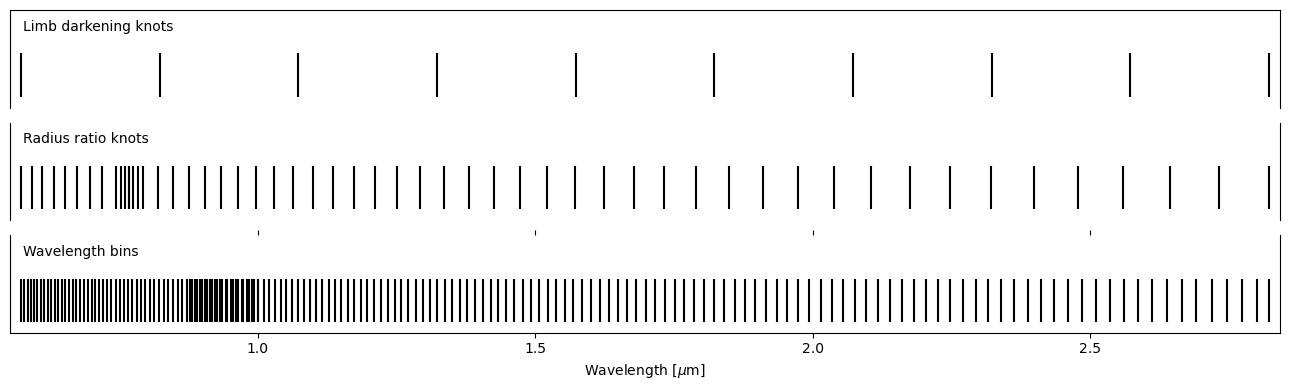

In [4]:
ts = load_model("01a.fits", name='02a')
ts.plot_setup();

The loaded model contains the states the optimiser and the MCMC sampler were when the model was saved, so we can plot the original best-fit or posterior model solutions using the standard `ExoIris` methods.

In [5]:
pargs = dict(figsize=(13,8), res_args=dict(pmin=5, pmax=95), 
             trs_args=dict(xscale='log', ylim=(2.0, 2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

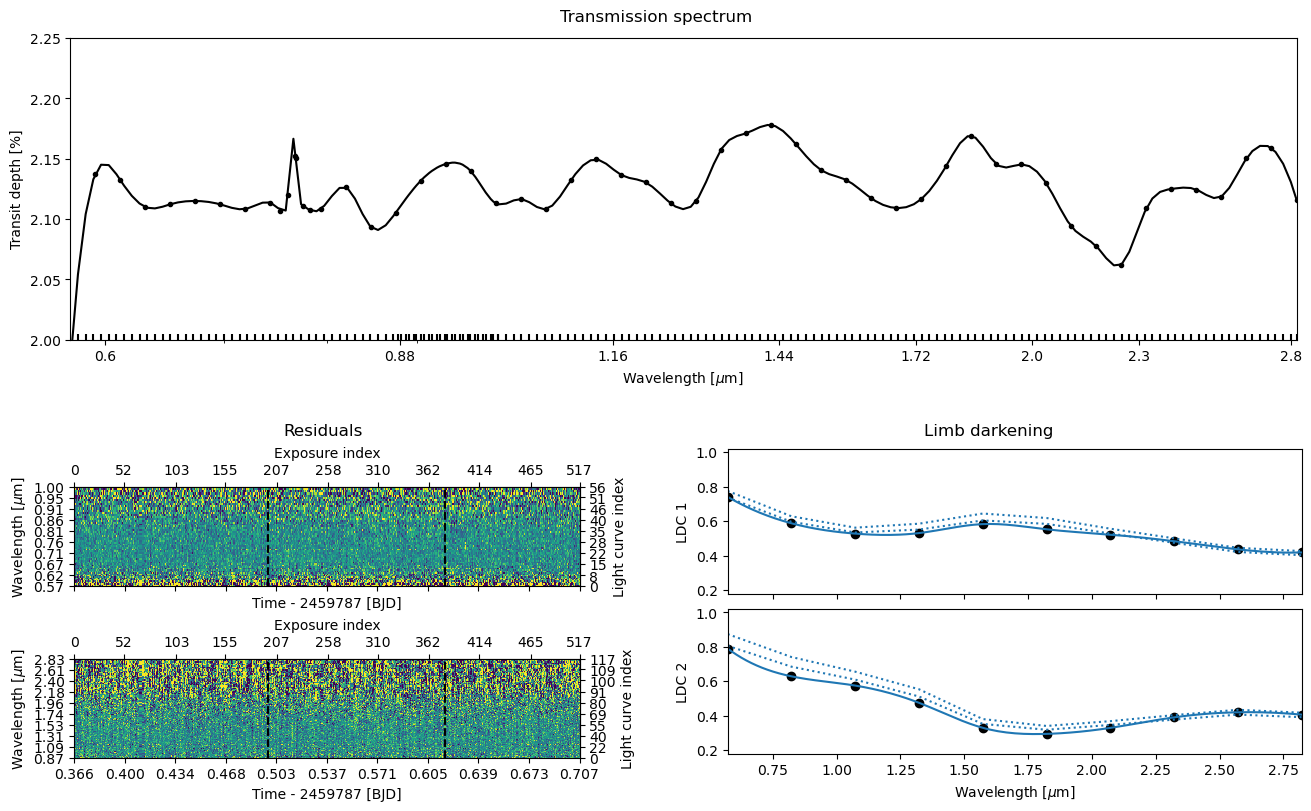

In [6]:
ts.plot_fit(result='fit', **pargs);

## Change the radius ratio knots

Next, we change the radius ratio knots. Let's just increase the knot resolution locally between 1.5 - 1.35 $\mu$m.

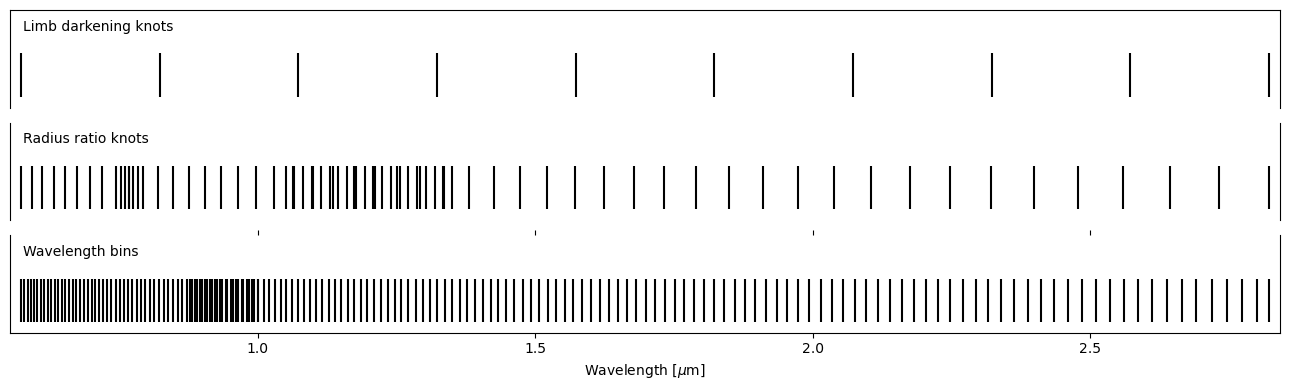

In [7]:
ts.add_radius_ratio_knots(linspace(1.05, 1.35, 20))
fig = ts.plot_setup();

Now, we ended up with some knots located very close to each other. This is not something we want (well, here, at least), so we can use the `exoiris.clean_knots` utility function to replace groups of knots too close to each other with single knots located at the group means. The function takes the list of knot locations, a minimum distance, and optionally arguments `lmin` and `lmax` that can be used to constrain the wavelength region where the cleaning is applied.

Here, we group the knots that are grouped closer than 0.0075 $\mu$m from each other starting from 1 $\mu$m upwards.

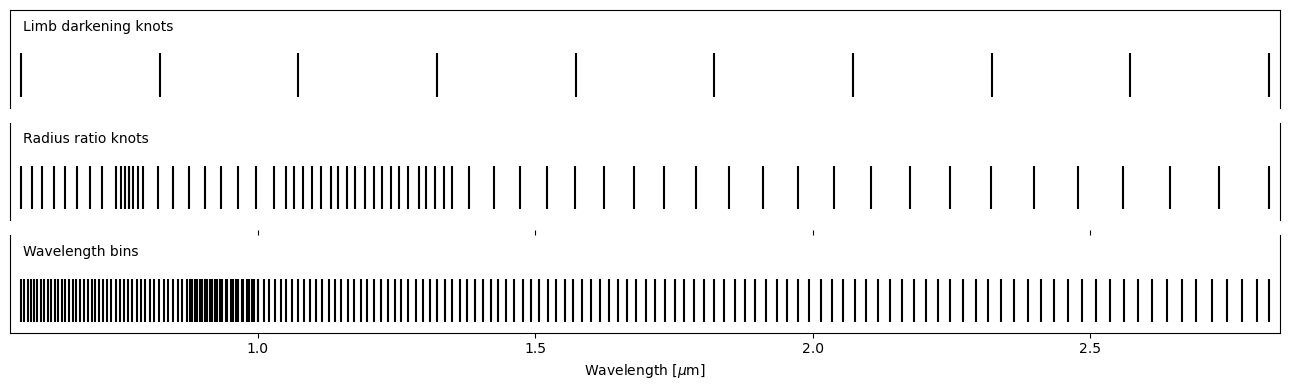

In [8]:
ts.set_radius_ratio_knots(clean_knots(ts.k_knots, 0.0075, lmin=1.0))
ts.plot_setup();

## Refit the model

Now that our new model has been set up, we can soon again continue with a round of global optimisation continued by posterior sampling. First, however, we need to check the number of model parameters, `ts.ndim`. Each radius ratio knot adds a free parameter to the model, and the emcee sampler requires that our parameter vector population size (number of walkers in emcee) is at least twice the number of model parameters. 

In [9]:
ts.ndim

94

So, we need a population size of at least 2 x 94 = 188, and decide to use 250. We could start the optimisation directly from the final state of the loaded analysis's optimiser or skip the optimisation altogether and continue MCMC sampling from the loaded analysis' sampler's state. Still, it's better to do an optimisation round after changing the model, and it is also best to start the optimiser with some dynamical range in the model parameters. 

We create the optimiser's initial population using the `ExoIris.create_initial_population` method by drawing 250 random parameter vectors from the saved low-resolution model posterior sample and adding some noise to the population. 

In [11]:
x0 = ts.create_initial_population(250, 'mcmc', add_noise=False)

After which we start the optimisation. Note that the `ExoIris.fit` method has two very similar arguments: `population` and `initial_population`. The difference is that the `population` argument resets the optimiser and starts from the given population, while the `initial_population` is used only if the optimiser hasn't been started yet (or hasn't been reset). This allows you to set the initial population and run the `ExoIris.fit` method multiple times with the same arguments so that each run continues from the previous state (instead of always starting from the `initial_population` what would happen with the `population` argument). 

In [12]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

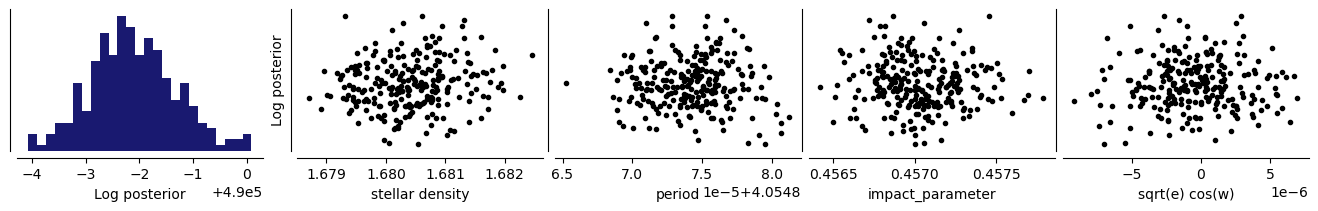

In [13]:
ts.fit(niter=2000, pool=pool, lnpost=lnpostf, initial_population=x0)

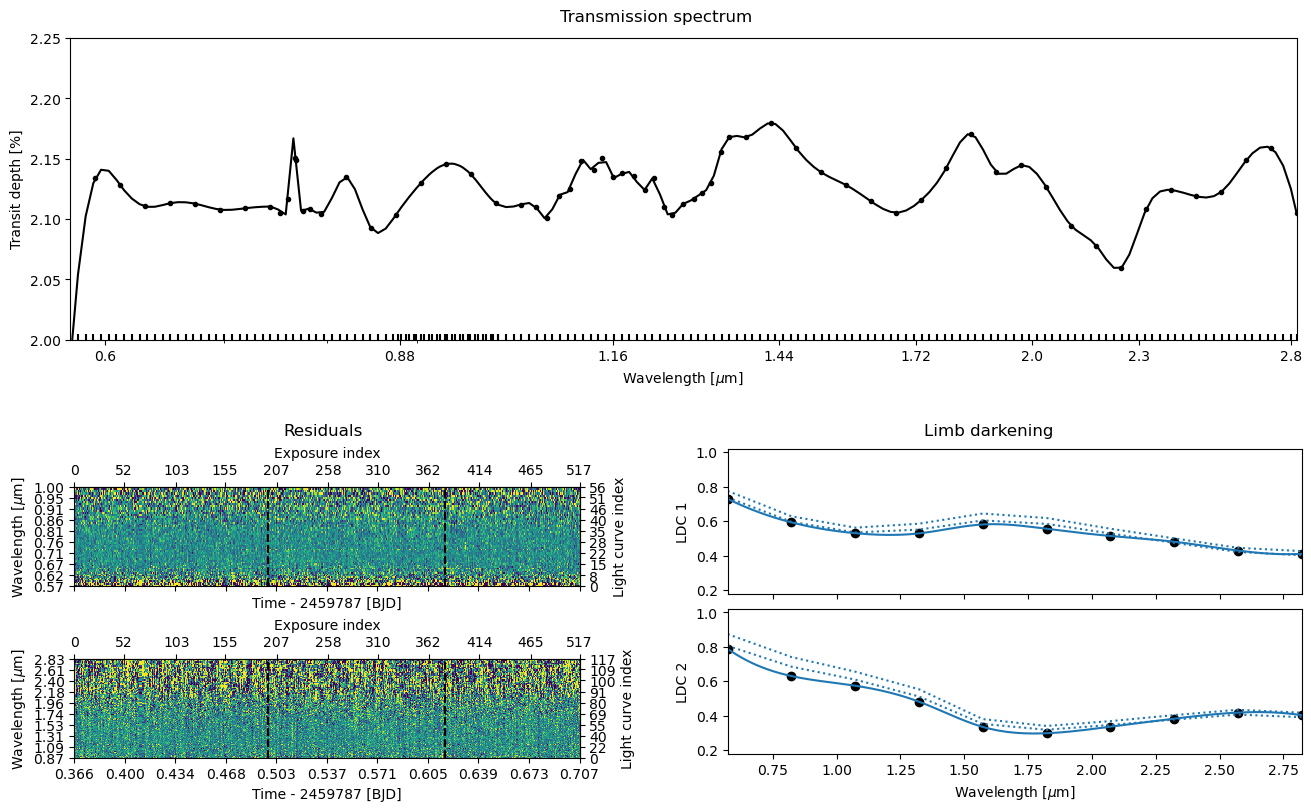

In [14]:
ts.plot_fit(result='fit', **pargs);

## Sample the posterior

Finally, we can continue with sampling, but first we need to reset the MCMC sampler using the `ExoIris.reset_sampler` method. Without this, the sampler would continue using the example 1 posterior chains instead of the new DE optimisation population.  

In [15]:
ts.reset_sampler()

In [16]:
ts.sample(1000, thin=10, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

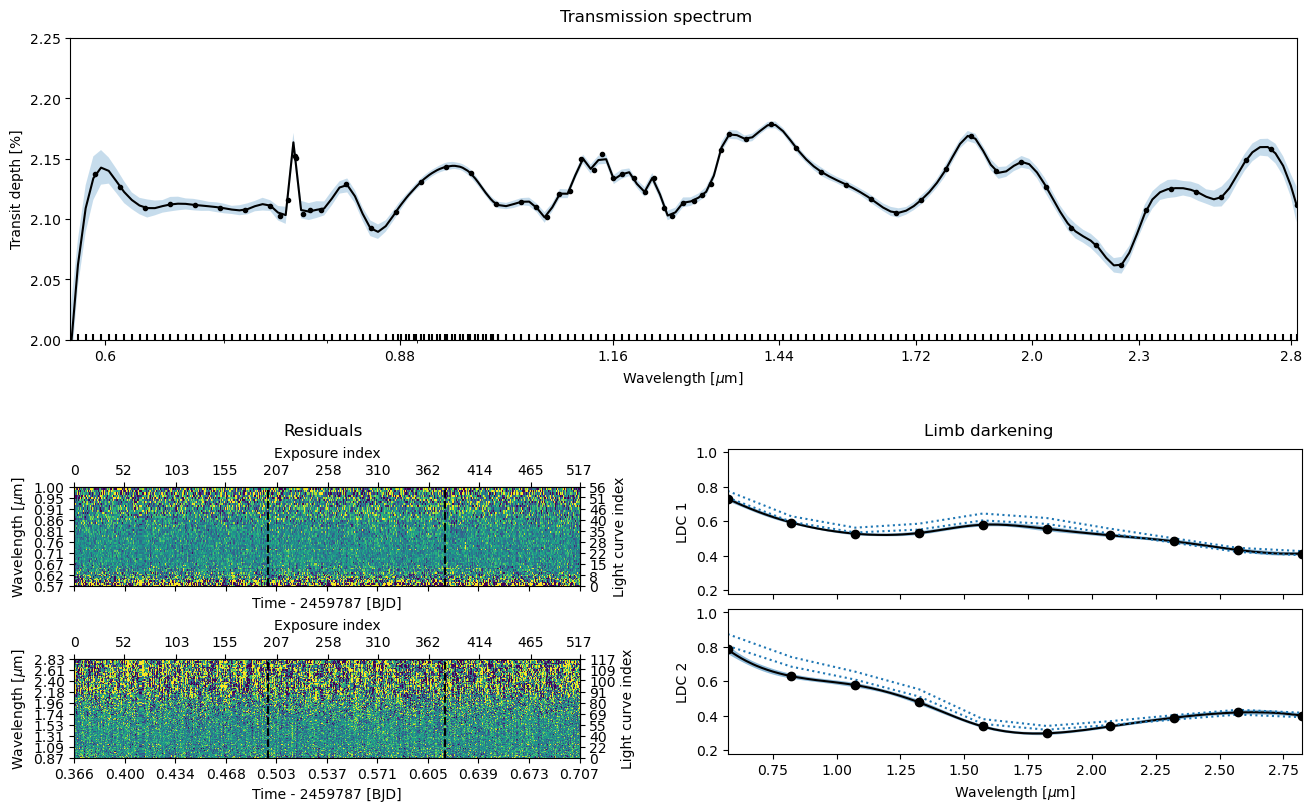

In [17]:
ts.plot_fit(result='mcmc', **pargs);

In [18]:
ts.save()

---

<center>&copy;2024 Hannu Parviainen</center>